# Introduction

Style transfer is a technique where the visual style of an image is transferred onto the content of another image. The goal is to generate a new image that preserves the content details of one image while adopting the artistic style of another image.
In this blog, we implement the *A Neural Algorithm for Artistic Style* [paper](https://arxiv.org/pdf/1508.06576.pdf) by Gatys, et al. which introduced the neural style tranfer.

NB: We'll be using the [little_ai](https://github.com/darkknightxi) library to implement the paper.

![](/content/style_transfer2.png)

# Setup

In [52]:
import pickle,gzip,math,os,time,shutil,torch,random,timm,torchvision,io,PIL
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torchvision import transforms
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
from fastcore.foundation import L, store_attr

from little_ai.datasets import *
from little_ai.conv import *
from little_ai.learner import *
from little_ai.activations import *
from little_ai.init import *
from little_ai.sgd import *
from little_ai.resnet import *

In [53]:
face_url = "https://images.pexels.com/photos/2690323/pexels-photo-2690323.jpeg?w=256"
spiderweb_url = "https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?w=256"

# Loading Images

Let's begin by writing a utility function that allows us to download images from their url.

In [54]:
def download_image(url):
    imgb = fc.urlread(url, decode=False)
    return torchvision.io.decode_image(tensor(list(imgb), dtype=torch.uint8)).float()/255.

content_im shape: torch.Size([3, 256, 256])


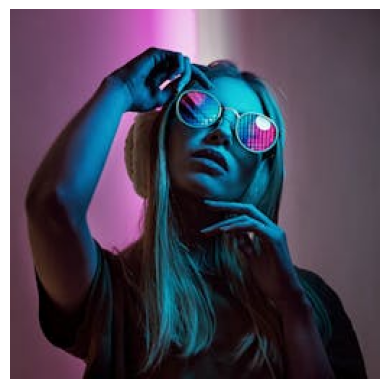

In [55]:
content_im = download_image(face_url).to(def_device)
print(f'content_im shape: {content_im.shape}')
show_image(content_im);

In [56]:
content_im.min(), content_im.max()

(tensor(0., device='cuda:0'), tensor(1., device='cuda:0'))

# Optimizing Images

Before moving on to implement style transfer, we'll first explore how we can optimize an image. We have seen how to optimize weights in a neural network. Let's now see how to optimize raw pixels of an image. In other words, how to get to the pixels of our original image starting from white noise.



We'll create a `LengthDataset` class that allows us to create a dummy dataloader. Our dataset is just a single image, but we still want to pass the image through our model multiple times to get better results. The `LengthDataset` class provides a convinient way to do this.

In [57]:
class LengthDataset():
    def __init__(self, length=1): self.length=length
    def __len__(self): return self.length
    def __getitem__(self, idx): return 0,0

def get_dummy_dls(length=100):
    return DataLoaders(DataLoader(LengthDataset(length), batch_size=1), # Train
                       DataLoader(LengthDataset(1), batch_size=1))      # Valid (length 1)

The model that we'll use simply converts the input image pixels into parameters (that is, they will be treated as neural net weights and can compute their gradients).

In [58]:
class TensorModel(nn.Module):
    def __init__(self, t):
        super().__init__()
        self.t = nn.Parameter(t.clone())
    def forward(self, x=0): return self.t

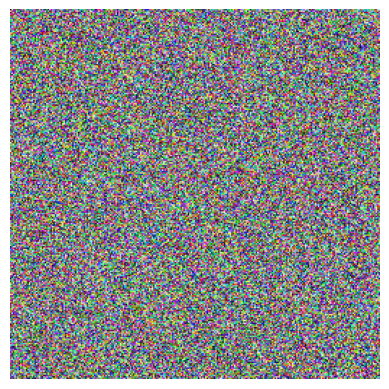

In [59]:
model = TensorModel(torch.rand_like(content_im))
show_image(model());

In [60]:
[p.shape for p in model.parameters()]

[torch.Size([3, 256, 256])]

We'll use a callback that calls the model and computes the loss.

In [61]:
class ImageOptCB(TrainCB):
    def predict(self, learn): learn.preds = learn.model()
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds)

To train our model, we use a mean squared error loss function. We create 100 copies of the input and train for one epoch.

In [62]:
def loss_fn_mse(im):
    return F.mse_loss(im, content_im)

model = TensorModel(torch.rand_like(content_im))
cbs = [ImageOptCB(), ProgressCB(), MetricsCB(), DeviceCB()]
learn = Learner(model, get_dummy_dls(100), loss_fn_mse,
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1)

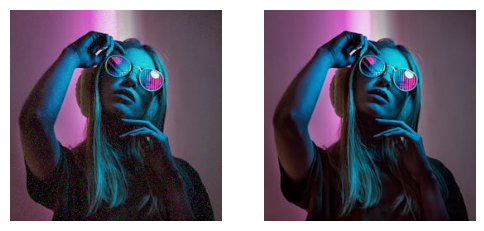

In [63]:
show_images([learn.model().clip(0, 1), content_im]);

The model is output is almost identical to the original image.

We can also visualize how the image is transformed by creating a logging callback.

In [64]:
class ImageLogCB(Callback):
    order = ProgressCB.order + 1
    def __init__(self, log_every=10): fc.store_attr(); self.images, self.i = [], 0
    def after_batch(self, learn):
        if self.i%self.log_every == 0: self.images.append(to_cpu(learn.preds.clip(0, 1)))
        self.i += 1
    def after_fit(self, learn): show_images(self.images);

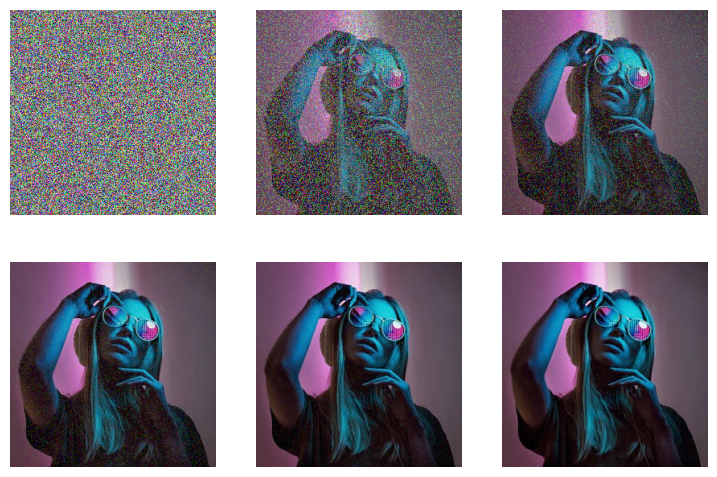

In [65]:
model = TensorModel(torch.rand_like(content_im))
learn = Learner(model, get_dummy_dls(150), loss_fn_mse,
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(30)])

# Getting features from VGG16

With the idea of optimizing images out of the way, lets start building style transfer. The first step is to extract features from an image using convolutional neural networks. The original paper used the VGG 16 network, so we too will stick with it.

We're going to peek inside a small CNN and extract the outputs of different layers. This [paper](https://distill.pub/2017/feature-visualization/) talks about how deep CNNs 'learn' to classify images. Early layers tend to capture gradients and textures, while later layers tend towards more complex types of feature. We're going to exploit this hierarchy for artistic purposes, but being able to choose what kind of feature you'd like to use when comparing images has a number of other useful applications.

## Load VGG network

In [66]:
print(timm.list_models('*vgg*'))

['repvgg_a0', 'repvgg_a1', 'repvgg_a2', 'repvgg_b0', 'repvgg_b1', 'repvgg_b1g4', 'repvgg_b2', 'repvgg_b2g4', 'repvgg_b3', 'repvgg_b3g4', 'repvgg_d2se', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


In [67]:
vgg16 = timm.create_model('vgg16', pretrained=True).to(def_device).features

In [68]:
vgg16

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

## Normalize Images

This model expects images normalized with the same stats as those used during training, which in this case requires the stats of the ImageNet dataset.

In [69]:
imagenet_mean = tensor([0.485, 0.456, 0.406])
imagenet_std = tensor([0.229, 0.224, 0.225])

In [70]:
def normalize(img):
    imagenet_mean = tensor([0.485, 0.456, 0.406])[:, None, None].to(def_device)
    imagenet_std = tensor([0.229, 0.224, 0.225])[:, None, None].to(def_device)
    return (img - imagenet_mean)/ imagenet_std

In [71]:
normalize(content_im).min(), normalize(content_im).max()

(tensor(-2.1179, device='cuda:0'), tensor(2.6400, device='cuda:0'))

In [72]:
normalize(content_im).mean(dim=(1, 2))

tensor([-0.9724, -0.9594, -0.4191], device='cuda:0')

## Getting intermediate representations

We want to feed some data through the network, storing the outputs of different layers. Here's one way to do this:

In [73]:
def calc_features(imgs, target_layers=(18, 25)):
    x = normalize(imgs)
    feats = []
    for i, layer in enumerate(vgg16[:max(target_layers)+1]):
        x = layer(x)
        if i in target_layers:
            feats.append(x.clone())
    return feats

In [74]:
feats = calc_features(content_im)
[f.shape for f in feats]

[torch.Size([512, 32, 32]), torch.Size([512, 16, 16])]

# Optimizing an image with Content Loss

To start with, let's try optimizing an image by comparing it's features (from two later layers) with those from the target image. If our theory is right, we should see the structure of the target emerge from the noise without necessarily seeing a perfect re-production of the target like we did in the previous MSE loss example.

In [75]:
class ContentLossToTarget():
    def __init__(self, target_im, target_layers=(18, 25)):
        fc.store_attr()
        with torch.no_grad():
            self.target_features = calc_features(target_im, target_layers)
    def __call__(self, input_im):
        return sum((f1-f2).pow(2).mean() for f1, f2 in
                   zip(calc_features(input_im, self.target_layers), self.target_features))

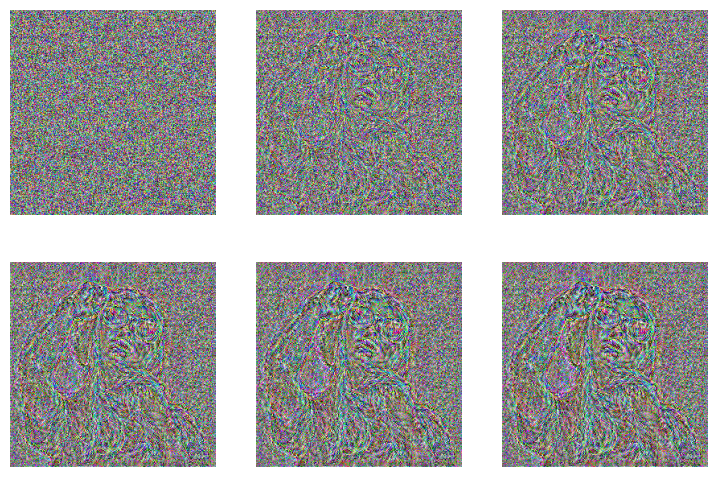

In [76]:
loss_fn_perceptual = ContentLossToTarget(content_im)
model = TensorModel(torch.rand_like(content_im))
learn = Learner(model, get_dummy_dls(150), loss_fn_perceptual,
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(log_every=30)])

We can see a silhoutte of the woman appearing in the noise. Since we are only looking at the later layers, the colors and other details are not being picked by the model.

**Choosing the layers determines the kind of features that are important:**

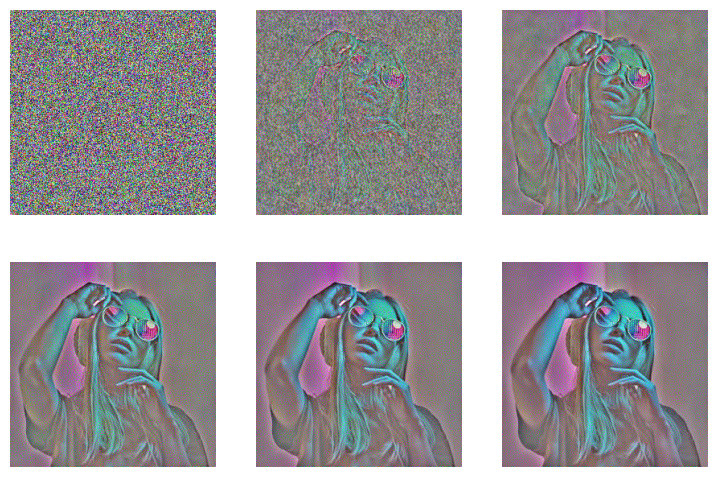

In [77]:
loss_function_perceptual = ContentLossToTarget(content_im, target_layers=(1, 6))
model = TensorModel(torch.rand_like(content_im))
learn = Learner(model, get_dummy_dls(150), loss_function_perceptual,
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(log_every=30)])

# Style Loss with Gram Matrix

So, we know how to extract feature maps. The next thing we'd like to do is find a way to capture the style of an input image, based on those early layers and the kinds of textural feature that they learn. Unfortunately, we can't just compare the feature maps from some early layers since these 'maps' encode information spatially - which we don't want!

So, we need a way to measure what kinds of style features are present, and ideally which kinds occur together, without worrying about where these features occur in the image.

Enter something called the Gram Matrix. The idea here is that we'll measure the correlation between features. Given a feature map with `f` features in an `h` x `w` grid, we'll flatten out the spatial component and then for every feature we'll take the dot product of that row with itself, giving an `f` x `f` matrix as the result. Each entry in this matrix quantifies how correlated the relevant pair of features are and how frequently they occur - exactly what we want. In this diagram each feature is represented as a colored dot.

Re-creating the diagram operations in code:

In [78]:
t = tensor([[0, 1, 0, 1, 1, 0, 0, 1, 1],
            [0, 1, 0, 1, 0, 0, 0, 0, 1],
            [1, 0, 1, 1, 1, 1, 1, 1, 0],
            [1, 0, 1, 1, 0, 1, 1, 0, 0]])

In [79]:
torch.einsum('fs, gs -> fg', t, t)

tensor([[5, 3, 3, 1],
        [3, 3, 1, 1],
        [3, 1, 7, 5],
        [1, 1, 5, 5]])

In [80]:
t.matmul(t.T)

tensor([[5, 3, 3, 1],
        [3, 3, 1, 1],
        [3, 1, 7, 5],
        [1, 1, 5, 5]])

## Trying it out

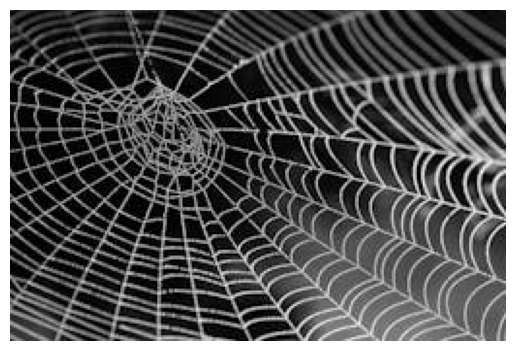

In [81]:
style_im = download_image(spiderweb_url).to(def_device)
show_image(style_im);

In [82]:
def calc_grams(img, target_layers=(1, 6, 11, 18, 25)):
    return L(torch.einsum('chw, dhw -> cd', x, x)/(x.shape[-1]*x.shape[-1])
             for x in calc_features(img, target_layers))

In [83]:
style_grams = calc_grams(style_im)

In [84]:
[g.shape for g in style_grams]

[torch.Size([64, 64]),
 torch.Size([128, 128]),
 torch.Size([256, 256]),
 torch.Size([512, 512]),
 torch.Size([512, 512])]

In [85]:
style_grams.attrgot('shape')

(#5) [torch.Size([64, 64]),torch.Size([128, 128]),torch.Size([256, 256]),torch.Size([512, 512]),torch.Size([512, 512])]

In [86]:
class StyleLossToTarget():
    def __init__(self, target_im, target_layers=(1, 6, 11, 18, 25)):
        fc.store_attr()
        with torch.no_grad(): self.target_grams = calc_grams(target_im, self.target_layers)
    def __call__(self, input_im):
        return sum((f1-f2).pow(2).mean() for f1, f2 in
                   zip(calc_grams(input_im, self.target_layers), self.target_grams))

In [87]:
style_loss = StyleLossToTarget(style_im)

In [88]:
style_loss(content_im)

tensor(178.9305, device='cuda:0', grad_fn=<AddBackward0>)

# Style Transfer

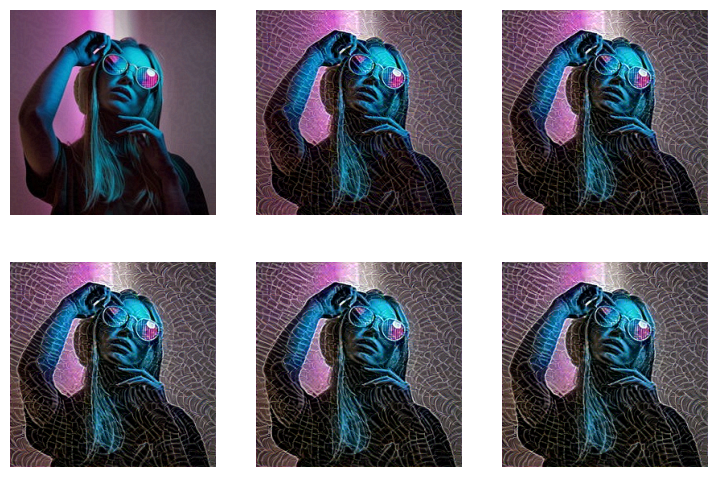

In [89]:
model = TensorModel(content_im) # Start from content image
style_loss = StyleLossToTarget(style_im)
content_loss = ContentLossToTarget(content_im)
def combined_loss(x):
    return style_loss(x) + content_loss(x)
learn = Learner(model, get_dummy_dls(150), combined_loss, lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(30)])

And trying with random starting image, weighting the style loss lower, using different layers:

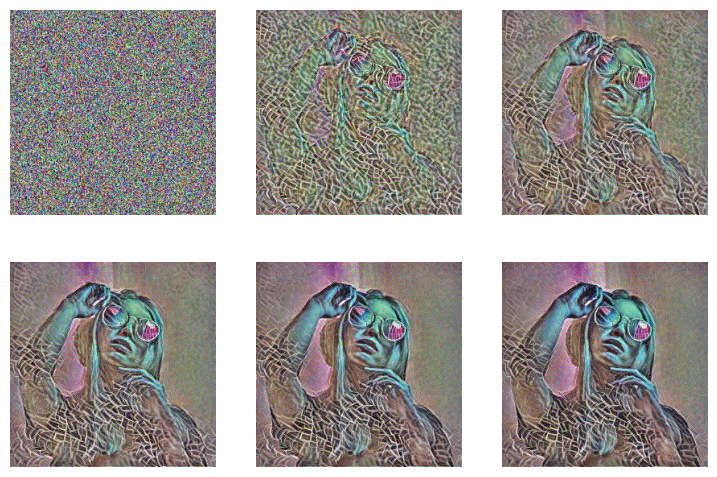

In [90]:
model = TensorModel(torch.rand_like(content_im))
style_loss = StyleLossToTarget(style_im)
content_loss = ContentLossToTarget(content_im, target_layers=(6, 18, 25))
def combined_loss(x):
    return style_loss(x) * 0.2 + content_loss(x)
learn = Learner(model, get_dummy_dls(300), combined_loss, lr=5e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(60)])

# Non-little_ai version

<Axes: >

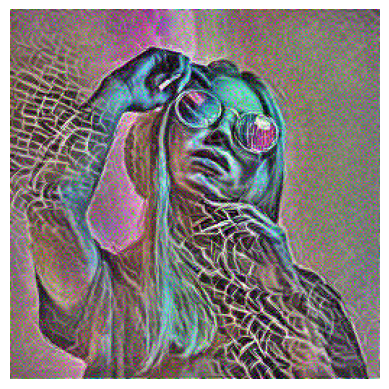

In [91]:
# The image to be optimized
im = torch.rand(3, 256, 256).to(def_device)
im.requires_grad = True

# Setup the optimizer
opt = torch.optim.Adam([im], lr=5e-2)

# Define the loss function
content_loss = ContentLossToTarget(content_im, target_layers=[6, 18, 25])
style_loss = StyleLossToTarget(style_im)
def combined_loss(x):
    return style_loss(x) * 0.2 + content_loss(x)

# Optimization loop
for i in range(300):
    loss = combined_loss(im)
    loss.backward()
    opt.step()
    opt.zero_grad()

# Show the result
show_image(im.clip(0, 1))